# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [177]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [178]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

print(rncp.head())

   Categorie                                text_certifications
0          1  Responsable de chantiers de bûcheronnage manue...
1          1  Responsable de chantiers de bûcheronnage manue...
2          1                                 Travaux forestiers
3          1                                              Forêt
4          1                                              Forêt


In [179]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [180]:
classifier.classes_ = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [181]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


In [182]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 40
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

print('Number of documents:', len(texts_reduced))

Number of documents: 2358


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [183]:
from sklearn.model_selection import train_test_split

# Rest of your code
train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced, labels_reduced, test_size=0.2)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [184]:
# Imports
import nltk
from nltk.corpus import stopwords

# Download the stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

[nltk_data] Downloading package stopwords to C:\Users\Pierre
[nltk_data]     Marchetti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<div class='alert alert-block alert-info'>
            Code:</div>

In [185]:
from nltk.tokenize import word_tokenize
# Look at the data and apply the appropriate pre-processing
print(train_texts[0])

# Lowercase
train_texts = [text.lower() for text in train_texts]

# Remove punctuation
train_texts = [re.sub(r'[^\w\s]', '', text) for text in train_texts]

# Remove numbers
train_texts = [re.sub(r'[0-9]', '', text) for text in train_texts]

# Remove stopwords
train_texts = [' '.join([word for word in text.split() if word not in stop_words]) for text in train_texts]

print(train_texts[0])
print(word_tokenize(train_texts[0]))

Responsable de la gestion des ressources humaines
responsable gestion ressources humaines
['responsable', 'gestion', 'ressources', 'humaines']


Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [186]:
def vocabulary(corpus, count_threshold=0, voc_threshold=10000):
    """    
    Function using word counts to build a vocabulary - can be improved with a second parameter for 
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit 
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency   
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    
    for sent in corpus:
        for word in sent.split():
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    filtered_word_counts = {word: word_counts[word] for word in word_counts if word_counts[word] >= count_threshold} # Filter according to count_threhshold        
    sorted_words = sorted(filtered_word_counts, key=filtered_word_counts.get, reverse=True) # Extract the words according to frequency
    filtered_words = sorted_words[:voc_threshold] # Remove the words above voc-threshold
    words = filtered_words + ['UNK'] # Add UNK
    vocabulary = {word: idx for idx, word in enumerate(words)}
    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

Voc, word_counts = vocabulary(train_texts)
print(Voc)
print(word_counts)

{'spécialité': 0, 'mention': 1, 'sciences': 2, 'santé': 3, 'ingénieur': 4, 'diplômé': 5, 'gestion': 6, 'technologies': 7, 'domaine': 8, 'droit': 9, 'management': 10, 'master': 11, 'nationale': 12, 'génie': 13, 'systèmes': 14, 'professionnelle': 15, 'option': 16, 'informatique': 17, 'métiers': 18, 'humaines': 19, 'sociales': 20, 'développement': 21, 'luniversité': 22, 'lecole': 23, 'finalité': 24, 'communication': 25, 'langues': 26, 'supérieure': 27, 'arts': 28, 'responsable': 29, 'polytechnique': 30, 'linstitut': 31, 'manager': 32, 'fiche': 33, 'diplôme': 34, 'industrielle': 35, 'economie': 36, 'matériaux': 37, 'national': 38, 'recherche': 39, 'ingénierie': 40, 'lécole': 41, 'mécanique': 42, 'lettres': 43, 'réseaux': 44, 'environnement': 45, 'production': 46, 'physique': 47, 'économie': 48, 'sécurité': 49, 'marketing': 50, 'appliquées': 51, 'lenvironnement': 52, 'technologie': 53, 'qualité': 54, 'chef': 55, 'mathématiques': 56, 'licence': 57, 'histoire': 58, 'projet': 59, 'biologie': 6

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

The document does not specify a particular vocabulary size, but given the nature of the task (simplifying text), a smaller, more basic vocabulary may be more appropriate. This would ensure the simplified text is more widely understandable.

Further pre-processing could be beneficial. The document mentions that the text should be "syntactically controlled", so additional steps to ensure correct syntax and grammar could be useful. This might include tools to check for correct sentence structure, subject-verb agreement, and proper punctuation.

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

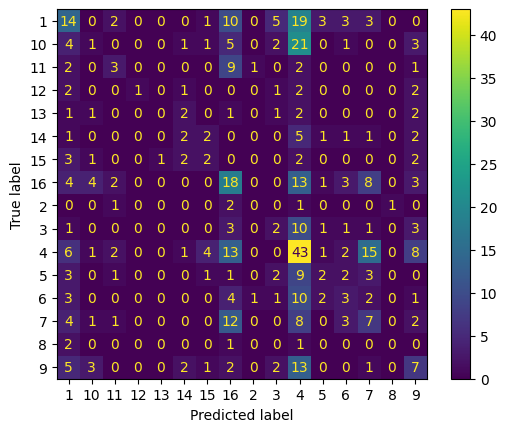

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Create the vectorizer and the classifier
vectorizer = CountVectorizer()
classifier = LogisticRegression()

# Vectorize the training texts
X_count = vectorizer.fit_transform(train_texts)

# Train the classifier
classifier.fit(X_count, train_labels)

# Vectorize the test texts
X_count_test = vectorizer.transform(test_texts)

# Predict the labels
predicted_labels = classifier.predict(X_count_test)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

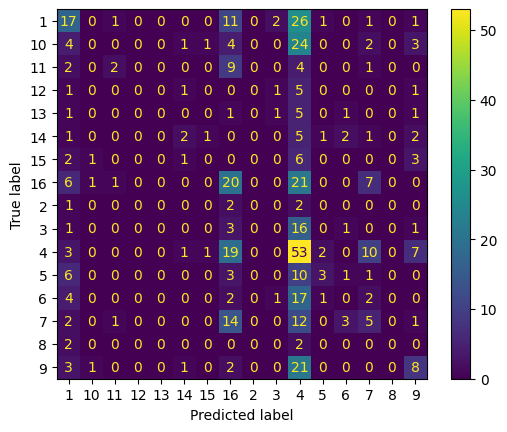

In [188]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create the vectorizer and the classifier
vectorizer = TfidfVectorizer()
classifier = LogisticRegression()

# Vectorize the training texts
X_tfidf = vectorizer.fit_transform(train_texts)

# Train the classifier
classifier.fit(X_tfidf, train_labels)

# Vectorize the test texts
X_tfidf_test = vectorizer.transform(test_texts)

# Predict the labels
predicted_labels = classifier.predict(X_tfidf_test)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

(1886, 300)


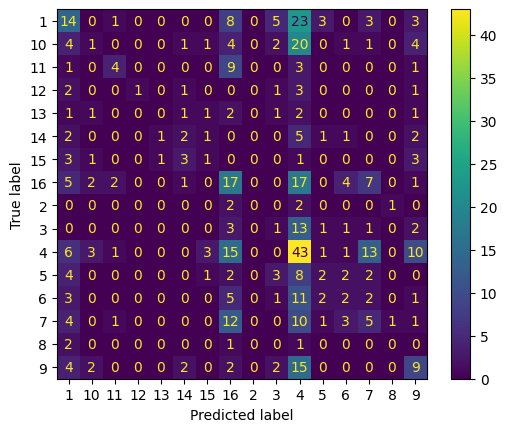

In [189]:
from sklearn.decomposition import TruncatedSVD

# Create the TruncatedSVD model
svd = TruncatedSVD(n_components=300)

# Fit and transform the bag-of-words representations
X_svd = svd.fit_transform(X_count)

# Print the shape of the reduced representations
print(X_svd.shape)

# Train the classifier
classifier.fit(X_svd, train_labels)

# Transform the test set
X_svd_test = svd.transform(X_count_test)

# Predict the labels
predicted_labels = classifier.predict(X_svd_test)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

(1886, 300)


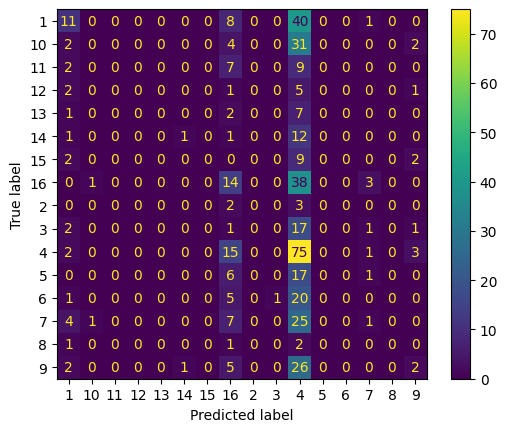

In [190]:
from sklearn.decomposition import LatentDirichletAllocation

# Create the LDA model
lda = LatentDirichletAllocation(n_components=300)

# Fit and transform the bag-of-words representations
X_lda = lda.fit_transform(X_count)

# Print the shape of the reduced representations
print(X_lda.shape)

# Train the classifier
classifier.fit(X_lda, train_labels)

# Transform the test set
X_lda_test = lda.transform(X_count_test)

# Predict the labels
predicted_labels = classifier.predict(X_lda_test)

# Compute the confusion matrix
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

If we wanted to find this hyperparameter through the data, we could fit the model with different number of topics and compute the perplexity score for each. Then we could find the maximum for perplexity score.

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [191]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        sent = sent.split()
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary[word] for word in sent if word in vocabulary]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
                sent_idx.append(len(vocabulary)-1) # This adds an Unkown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i-window):i]       
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1/(i-j)
                M[ctx_idx, idx] += 1/(i-j)
    return M  

In [192]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        indexes = [vocabulary[word] for word in text.split() if word in vocabulary] # Indexes of words in the sentence obtained thanks to the vocabulary
        sentrep = np_func(embeddings[indexes], axis=0) # Embeddings of words in the sentence, aggregated thanks to the function
        representations.append(sentrep)
    representations = np.array(representations)    
    return representations

In [193]:
def co_occurrence_to_ppmi(co_occurrence_matrix):
    """
    Transform a co-occurrence matrix into a PPMI (Positive Pointwise Mutual Information) matrix.
    
    Parameters:
    co_occurrence_matrix : numpy array
        Co-occurrence matrix.
        
    Returns:
    ppmi_matrix : numpy array
        PPMI matrix.
    """
    # Calculate row and column sums
    row_sums = np.sum(co_occurrence_matrix, axis=1)
    col_sums = np.sum(co_occurrence_matrix, axis=0)
    total_sum = np.sum(row_sums)
    
    # Calculate probabilities
    row_probs = row_sums / total_sum
    col_probs = col_sums / total_sum
    
    # Calculate PPMI values
    ppmi_values = np.log(co_occurrence_matrix / (np.outer(row_probs, col_probs) + 1e-8)) / np.log(2)
    ppmi_values[ppmi_values < 0] = 0
    
    return ppmi_values

<div class='alert alert-block alert-info'>
            Code:</div>

C:\Users\Pierre Marchetti\AppData\Local\Temp\ipykernel_15188\3135044037.py:23: RuntimeWarning: divide by zero encountered in log
  ppmi_values = np.log(co_occurrence_matrix / (np.outer(row_probs, col_probs) + 1e-8)) / np.log(2)


Co-occurrence matrix:
[[  0.28571429 114.32348485  85.38813131 ...   0.33333333   0.25
    0.        ]
 [114.32348485   1.25       175.33297258 ...   0.           0.
    0.        ]
 [ 85.38813131 175.33297258  32.95637141 ...   0.           0.
    0.        ]
 ...
 [  0.33333333   0.           0.         ...   0.           1.
    0.        ]
 [  0.25         0.           0.         ...   1.           0.
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]

PPMI matrix:
[[ 6.04016206 15.24571972 15.17352131 ... 16.18627923 16.18222886
   0.        ]
 [15.24571972  9.29189383 16.77273455 ...  0.          0.
   0.        ]
 [15.17352131 16.77273455 14.71008129 ...  0.          0.
   0.        ]
 ...
 [16.18627923  0.          0.         ...  0.         26.14851639
   0.        ]
 [16.18222886  0.          0.         ... 26.14851639  0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-pack

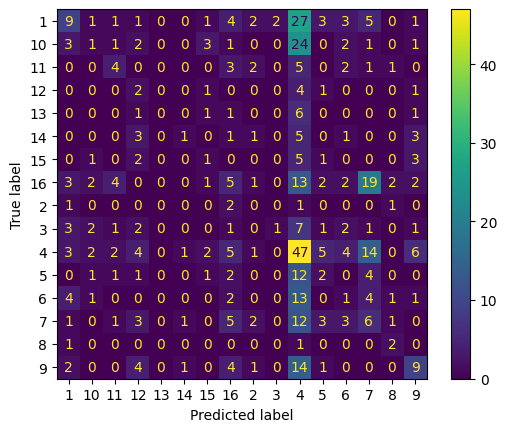

In [194]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension

# Step 1a: Obtain the co-occurence matrix
co_occurence = co_occurence_matrix(train_texts, Voc)

# Step 1b: Transform the co-occurrence matrix into the PPMI matrix and compare the results
ppmi_matrix = co_occurrence_to_ppmi(co_occurence)
print("Co-occurrence matrix:")
print(co_occurence)
print("\nPPMI matrix:")
print(ppmi_matrix)

# Step 2: Apply SVD to obtain word embeddings
svd = TruncatedSVD(n_components=300)

# Step 3: Obtain document representations
train_representations = sentence_representations(train_texts, Voc, svd.fit_transform(co_occurence))

# Step 4: Train a classifier on document representations
classifier = LogisticRegression()
classifier.fit(train_representations, train_labels)

test_representations = sentence_representations(test_texts, Voc, svd.transform(co_occurence))  # Transform test data using the same SVD

# Step 5: Evaluate the classifier
test_representations = np.nan_to_num(test_representations)  # Remove NaN values
predicted_labels = classifier.predict(test_representations)
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-pack

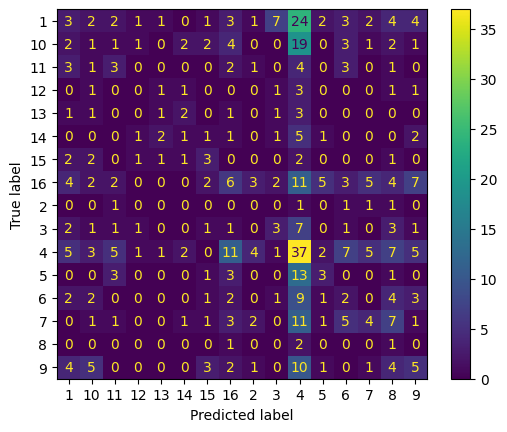

In [195]:
# Step 3: Obtain document representations
train_representations = sentence_representations(train_texts, Voc, svd.fit_transform(ppmi_matrix))

# Step 4: Train a classifier on document representations
classifier = LogisticRegression()
classifier.fit(train_representations, train_labels)

test_representations = sentence_representations(test_texts, Voc, svd.transform(ppmi_matrix))  # Transform test data using the same SVD

# Step 5: Evaluate the classifier
test_representations = np.nan_to_num(test_representations)  # Remove NaN values
predicted_labels = classifier.predict(test_representations)
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [196]:
from gensim.models import Word2Vec

In [197]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [198]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.
preprocessed_corpus = [word_tokenize(text) for text in train_texts]

In [199]:
model.train(preprocessed_corpus, total_examples=model.corpus_count, epochs=5, report_delay=1)

Exception in thread Thread-43 (_job_producer):
Traceback (most recent call last):
  File "C:\Users\Pierre Marchetti\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "C:\Users\Pierre Marchetti\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Pierre Marchetti\Downloads\TP_IMA204_activecontours_2023-24_FINAL\TP_IMA204_activecontours_2023-24_FINAL\.venv\Lib\site-packages\gensim\models\word2vec.py", line 1222, in _job_producer
    epoch_progress = 1.0 * pushed_words / total_words
                     ~~~~~~~~~~~~~~~~~~~^~~~~~~~~~~~~
TypeError: unsupported operand type(s) for /: 'float' and 'NoneType'


Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [ ]:
train_representations = sentence_representations(train_texts, Voc, model.wv)

classifier = LogisticRegression()
classifier.fit(train_representations, train_labels)

test_representations = sentence_representations(test_texts, Voc, model.wv)  # Transform test data using the same SVD

test_representations = np.nan_to_num(test_representations)  # Remove NaN values
predicted_labels = classifier.predict(test_representations)
cm = confusion_matrix(test_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
disp.plot()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

The big issue with the dataset is the time it takes to update embeddings on a large dataset. This is a huge problem when the number of documents is large. This is due to the use of a single worker to process the documents, which can be improved by implementing parallel processing and batch processing.